Using the nwb_photostim package

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from pynwb import NWBFile
from file_classes import SpatialLightModulator, PhotostimulationDevice, HolographicPattern, PhotostimulationSeries, StimulusPresentation
import numpy as np
from dateutil.tz import tzlocal
from pynwb import NWBHDF5IO
from datetime import datetime


## Spatial light modulator

In [46]:
slm = SpatialLightModulator(name='example_SLM', description="example SLM", manufacturer="SLM manufacturer", size=[500, 500])

## PhotostimulationDevice

In [47]:
photostim_dev = PhotostimulationDevice(name='photostimulation_device', description="example photostimulation device",
                                       manufacturer="device manufacturer", type='LED', wavelength=320, opsin="example opsin", slm=slm)
nwbfile = NWBFile(
    'my first synthetic recording',
    'EXAMPLE_ID',
    datetime.now(tzlocal()),
)
nwbfile.add_device(photostim_dev)

photostimulation_device file_classes.PhotostimulationDevice at 0x140443974046752
Fields:
  description: example photostimulation device
  manufacturer: device manufacturer
  opsin: example opsin
  slm: example_SLM file_classes.SpatialLightModulator at 0x140443974050304
Fields:
  description: example SLM
  manufacturer: SLM manufacturer
  size: [500 500]

  type: LED
  wavelength: 320

## Holographic stimulation pattern

The container `HolographicPattern` is used to store data corresponding to the pattern of stimulation for a given trial. The primary
input to the function is a set of ROIs, that denote whether a given pixel is stimulated (encoded as 1) or not stimulated (encoded as 0)
when that stimulus is presented. There are two ways to specify the ROIs: as an `image_mask_roi` or a `pixel_roi` (described below).

### ROIs specified using an image mask

In the `image_mask_roi`, the input to `HolographicPattern` is an array or list with dimensionality `[width, height]` or `[width, height, depth`] covering the entire field of view. ROIs that are stimulated are encoded by 1 values, and unstimulated regions by zeros.

In the example below, we simulate a `[50, 50]` pixel field of view, and randomly select 5 ROIs with a width and height of 5 pixels. To store the pattern in a `HolographicPattern` object, we use specify the ROIs using the `mask_roi` input argument on construction. A helper method `show_mask()` shows the simulated stimulated regions.

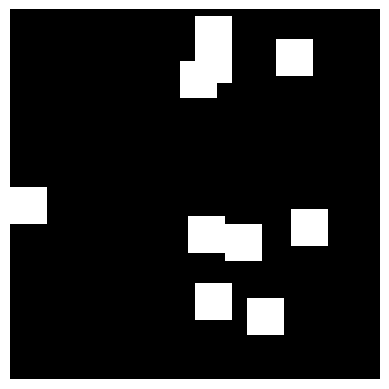

In [50]:
image_mask_roi = np.zeros((50, 50))

n_rois = 5
for _ in range(n_rois):
    x = np.random.randint(0, 45)
    y = np.random.randint(0, 45)
    mask_roi[x:x + 5, y:y + 5] = 1

hp_1 = HolographicPattern(name='pattern 1', image_mask_roi=mask_roi)
hp_1.show_mask()

### ROIs specified by the center and diameter of each region

Additionally, we provide a second method for specifying ROIs, the `pixel_roi`. `pixel_roi` inputs are a two- or three-dimensional vector of size `[num_rois, 3]` (in 2D stimulation) or `[num_rois, 4]` (in 3D stimulation). In the 2D case, `pixel_roi` takes the form `[(x1, y1), (x2, y2), ...]`, where `x` and `y` values correspond with the center of the ROI (in pixels). Similarly, in the 3D case, each element in the input takes the form `(x, y, z)`, where `z` denotes the depth of stimulation.

As compared to `image_mask_roi`, `pixel_roi` construction require two additional specifications: `stimulation_diameter` and `dimension`. `stimulation_diameter` denotes, in pixels, the radius of the ROI centered at input location `(x, y)` or `(x, y, z)`. That is, each row of `pixel_roi` corresponds to an ROI at a given location, extending `stimulation_diameter` pixels in every direction. Additionally, the dimensions of the field of view, in pixels, must be specified by the `dimension` parameter, where `dimension=[width, height]` or `[width, height, depth]`.

An example of a `HolographicPattern` with a `pixel_roi` input is shown below. This example includes 5 randomly-selected ROIs in a `[100, 100]` field of view, with a `stimulation_diameter` of 8 pixels. We use the helper function `show_mask()` to visualize the pattern.

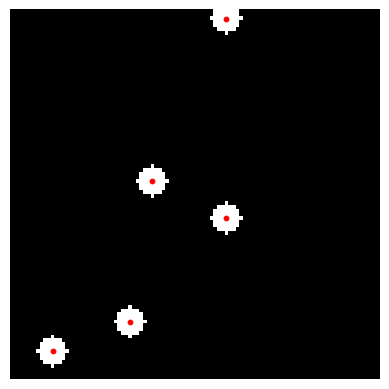

In [51]:
pixel_roi = []

for i in range(5):
    x = np.random.randint(0, 95)
    y = np.random.randint(0, 95)

    for ix in range(x, x + 1):
        for iy in range(y, y + 1):
            pixel_roi.append((ix, iy, 1))

hp_2 = HolographicPattern(name='pattern 2', pixel_roi=pixel_roi, stimulation_diameter=8, dimension=[100, 100])
hp_2.show_mask()

## Stimulation series

The presentation of a given stimulation pattern over time is stored via the `PhotostimulationSeries` container.



### Interval format

In the `'interval'` format, we store the onset and cessation of stimulus presentation using a 1D array consisting of the values 1 (stimulus on) and -1 (stimulus off). The corresponding times for the start and stop of the stimulus are specified via the `timestamps` property, where `data[i]==1` denotes that the stimulus was presented at time `timestamps[i]`, and `data[i+1]==-1` denotes it stopped at time `timestamps[i+1]` (time is specified in seconds). For example, in the cell below, we note that pattern `hp_1` was presented from seconds `0.5` to `1`, and then again from seconds `2` to `4`.

In [52]:
stim_series_1 = PhotostimulationSeries(name="series 1", format='interval', holographic_pattern=hp_1, data=[1, -1, 1, -1], timestamps=[0.5, 1, 2, 4])

While we can specify the `data` and `timestamps` directly, we can also initialize an empty `PhotostimulationSeries` (by not providing a `data` or `timestamps` input), and use the function `add_interval(start, stop)` to store the presentation of the stimulus from time `start` to time `stop`. In the example below, the first call indicates presentation of the stimulus between seconds `10` and `20`, and then again from seconds `35` to `40`. We can call the helper method `to_dataframe()` to display `data` and `timestamps` simultaneously.

In [53]:
stim_series_2 = PhotostimulationSeries(name="series 2", format='interval', holographic_pattern=hp_2)
stim_series_2.add_interval(10, 20)
stim_series_2.add_interval(35, 40)

print(stim_series_2.to_dataframe())

   data  timestamps
0   1.0        10.0
1  -1.0        20.0
2   1.0        35.0
3  -1.0        40.0


### Series format

In addition to the interval format, we can also encode presentation time series data as a "series." In this format, rather than indicating the start and stop of stimulation,`data` consists of a 1D array of 0s and 1s denoting whether a stimulus was on or off at a given time step. In the example below, we note that the data is `[0, 1, 0, 1, 1, 0]`, the rate (i.e., the rate at which data are sampled, in Hz) is `10`, and the `stimulus_duration` is `0.05` (meaning that, at each time point where the stimulus is "on", denoted by a value of 1, it remains on for 0.05 seconds). In the case of the fourth element (`data[3]=1`), for example, the `rate` indicates that this point corresponds to 0.4 seconds into the trial (since `rate=10`, meaning there are 10 evenly-sampled data points per second). Since the value of the element is `1`, the stimulus was presented at that time, for `stimulus_duration=0.05` seconds. Expressed as an interval, the fourth time step indicates the stimulus was presented from *t*=0.4 to *t=0.05*.

While less easily interpretable, we include `format=`series'` as an option for the time series format because it may more closely align with the data collection modalities used in photostimulation methods.

In [54]:
stim_series_3 = PhotostimulationSeries(name="series 3", holographic_pattern=hp_1, format='series', stimulus_duration = 0.05, data=[0, 1, 0, 1, 1, 0], rate=10.)
print(stim_series_3.to_dataframe())

   data  timestamps
0     0        0.00
1     1        0.05
2     0        0.10
3     1        0.15
4     1        0.20
5     0        0.25


In the example above, we use the `rate` parameter instead of `timestamps` to express the times `data` correspond to. In the `'series'` format, we can still specify timestamps directly, as we did for the interval series. Here, the data `data[i]` corresponds to an interval beginning at time `timestamps[i]` and ending at time `timestamps[i]+stimulus_duration`. Note that `PhotostimulationSeries` requires one of either `rate` or `timestamps` to be specified for the series format, in order for data to be added.

In addition to adding data directly, we can also add data using the `add_onset(time)` method, which denotes the onset of the stimulus at time `time` (for duration `stimulus_duration`).

In [55]:
stim_series_4 = PhotostimulationSeries(name="series 4", holographic_pattern=hp_2, format='series', stimulus_duration = 0.05, data=[0, 1, 0, 1], timestamps=[0, 0.5, 2, 4])
stim_series_4.add_presentation(5)
stim_series_4.add_presentation([10, 14, 50])
print(stim_series_4.to_dataframe())

   data  timestamps
0     0         0.0
1     1         0.5
2     0         2.0
3     1         4.0
4     1         5.0
5     1        10.0
6     1        14.0
7     1        50.0


The `add_presentation` function also works for the `'interval'` format:

In [57]:
stim_series_5 = PhotostimulationSeries(name="series 5", format='interval', holographic_pattern=hp_1, stimulus_duration=2)
stim_series_5.add_presentation(1)
stim_series_5.add_presentation([10, 18, 24])
print(stim_series_5.to_dataframe())

   data  timestamps
0   1.0         1.0
1  -1.0         3.0
2   1.0        10.0
3  -1.0        12.0
4   1.0        18.0
5  -1.0        20.0
6   1.0        24.0
7  -1.0        26.0


In [ ]:
sp = StimulusPresentation(name='test', description='test desc', photostimulation_device=photostim_dev, stimulus_method='asas')
sp.add_event_type(label='stim1', stimulus_description='d1', PhotostimulationSeries=photostim_series, HolographicPattern=hp)
sp.add_event_type(label='stim2', stimulus_description='d2', PhotostimulationSeries=photostim_series, HolographicPattern=hp)
sp.add_event_type(label='stim2', stimulus_description='d2', PhotostimulationSeries=photostim_series, HolographicPattern=hp)
print(sp.to_dataframe())

In [43]:
for stim in [stim_series_1, stim_series_2, stim_series_3, stim_series_4, stim_series_5]:
    nwbfile.add_stimulus(stim)

## PhotostimulationTable

In [13]:
sp = StimulusPresentation(name='test', description='test desc', photostimulation_device=photostim_dev, stimulus_method='asas')
sp.add_series(label='stim1', stimulus_description='d1', PhotostimulationSeries=photostim_series, HolographicPattern=hp)
sp.add_event_type(label='stim2', stimulus_description='d2', PhotostimulationSeries=photostim_series, HolographicPattern=hp)
sp.add_event_type(label='stim2', stimulus_description='d2', PhotostimulationSeries=photostim_series, HolographicPattern=hp)
print(sp.to_dataframe())

    label stimulus_description  \
id                               
0   stim1                   d1   
1   stim2                   d2   
2   stim2                   d2   

                               PhotostimulationSeries  \
id                                                      
0   photosim series file_classes.PhotostimulationS...   
1   photosim series file_classes.PhotostimulationS...   
2   photosim series file_classes.PhotostimulationS...   

                                   HolographicPattern  
id                                                     
0   HolographicPattern file_classes.HolographicPat...  
1   HolographicPattern file_classes.HolographicPat...  
2   HolographicPattern file_classes.HolographicPat...  


Displaying table

Plotting stimulation intervals

## Writing the file

In [14]:
from datetime import datetime
from dateutil.tz import tzlocal
from pynwb import NWBFile
from pynwb import NWBHDF5IO

nwb_file = NWBFile(session_description='test file', identifier='EXAMPLE_ID', session_start_time=datetime.now(tzlocal()))

with NWBHDF5IO("basics_tutorial.nwb", "w") as io:
    io.write(sp)

with NWBHDF5IO("basics_tutorial.nwb", "r", load_namespaces=True) as io:
    read_nwbfile = io.read()

ReferenceTargetNotBuiltError: HolographicPattern (test/HolographicPattern): Could not find already-built Builder for HolographicPattern 'HolographicPattern' in BuildManager

## Reading the file

In [3]:
import pynwb

file = "test.namespace.yaml"
tm = pynwb.get_type_map(file)
m = pynwb.get_manager(file)

In [7]:
pynwb.load_namespaces(file)
c = pynwb.get_class("PhotostimulationDevice", "test")

help(c)

Help on class PhotostimulationDevice in module abc:

class PhotostimulationDevice(pynwb.device.Device)
 |  PhotostimulationDevice(*args, **kwargs)
 |  
 |  Method resolution order:
 |      PhotostimulationDevice
 |      pynwb.device.Device
 |      pynwb.core.NWBContainer
 |      pynwb.core.NWBMixin
 |      hdmf.container.Container
 |      hdmf.container.AbstractContainer
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(*args, **kwargs)
 |      __init__(name, type, wavelength, slm, description=None, manufacturer=None, opsin=None, peak_pulse_power=None, power=None, pulse_rate=None)
 |      
 |      
 |      
 |      Args:
 |          name (:py:class:`~str`): the name of this device
 |          type (:py:class:`~str`): type of stimulation (laser or LED)
 |          wavelength (:py:class:`~float` or :py:class:`~numpy.float32` or :py:class:`~numpy.float64` or :py:class:`~numpy.int8` or :py:class:`~numpy.int16` or :py:class:`~numpy.int32` or :py:class:`~numpy.int64` o

In [13]:
help(c.slm)

Help on property:

    slm



In [10]:
c.__weakref__

<attribute '__weakref__' of 'AbstractContainer' objects>

In [30]:
import pandas as pd
from pynwb import register_class, load_namespaces
from pynwb.core import NWBContainer, NWBDataInterface
from pynwb.base import TimeSeries
from collections.abc import Iterable
from pynwb.device import  Device
from hdmf.utils import docval, popargs, get_docval, popargs_to_dict
from pynwb.core import DynamicTable, VectorData
import numpy as np
from hdmf.utils import docval, getargs, popargs, popargs_to_dict, get_docval, call_docval_func
import warnings
from pynwb.io.core import NWBContainerMapper
from pynwb import register_map
from pynwb.base import TimeSeries, TimeSeriesReferenceVectorData, TimeSeriesReference
from pynwb.file import MultiContainerInterface, NWBContainer
from hdmf.build import ObjectMapper
from hdmf.common.io.table import DynamicTableMap
import matplotlib.pyplot as plt


ns_path = "test.namespace.yaml"
load_namespaces(ns_path)
namespace = 'test'

@register_class('PhotostimulationDevice', namespace)
class PhotostimulationDevice(Device):
    """
    Device used in photostimulation.
    """

    __nwbfields__ = ({'name': 'slm', 'child': True}, 'type', 'wavelength','opsin', 'peak_pulse_power', 'power', 'pulse_rate')

    @docval(*get_docval(Device.__init__) + (
        {'name': 'slm', 'type': SpatialLightModulator, 'doc': 'spatial light modulator'},
        {'name': 'type', 'type': str, 'doc': 'type of stimulation (laser or LED)'},
        {'name': 'wavelength', 'type': (int, float), 'doc': 'wavelength of photostimulation'},
        {'name': 'opsin', 'type': str, 'doc': 'opsin used', 'default': None},
        {'name': 'peak_pulse_power', 'type': (int, float), 'doc': 'peak pulse power (J)', 'default': None},
        {'name': 'power', 'type': (int, float), 'doc': 'power (in milliwatts)', 'default': None},
        {'name': 'pulse_rate', 'type': (int, float), 'doc': 'pulse rate (Hz)', 'default': None}
    ))
    def __init__(self, **kwargs):
        keys_to_set = ('slm', 'type', 'wavelength','opsin', 'peak_pulse_power', 'power', 'pulse_rate')
        args_to_set = popargs_to_dict(keys_to_set, kwargs)
        super().__init__(**kwargs)

        for key, val in args_to_set.items():
            setattr(self, key, val)

@register_map(PhotostimulationDevice)
class PhotostimulationDeviceMap(NWBContainerMapper):
    def __init__(self, spec):
        print('hello')
        super().__init__(spec)
        self.map_spec('slm', self.spec.get_neurodata_type('SpatialLightModulator'))
        print(spec)

slm = SpatialLightModulator(name="slm", dimension=np.array([1, 2, 3]))
photostim_dev = PhotostimulationDevice(name="photostim_dev", description="photostim_device", type='LED',
                                               wavelength=320, slm=slm)

In [31]:
help(PhotostimulationDeviceMap)

Help on class PhotostimulationDeviceMap in module __main__:

class PhotostimulationDeviceMap(pynwb.io.core.NWBContainerMapper)
 |  PhotostimulationDeviceMap(spec)
 |  
 |  Method resolution order:
 |      PhotostimulationDeviceMap
 |      pynwb.io.core.NWBContainerMapper
 |      pynwb.io.core.NWBBaseTypeMapper
 |      hdmf.build.objectmapper.ObjectMapper
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, spec)
 |      __init__(spec)
 |      
 |      Create a map from AbstractContainer attributes to specifications
 |      
 |      Args:
 |          spec (:py:class:`~hdmf.spec.spec.DatasetSpec` or :py:class:`~hdmf.spec.spec.GroupSpec`): The specification for mapping objects to builders
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __abstractmethods__ = frozenset()
 |  
 |  constructor_args = {'name': <function ObjectMapper.get_container_name>...
 |  
 |  obj_attrs = {}
 |  
